# Matched Filtering

In this notebook we will construct our own matched filter and apply it to gw150914.

In [2]:
###IMPORTS
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 33.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 164.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 139.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 206.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 235.3 MB/s eta 0:00:00
   ━━━━━━━

In [3]:
from pycbc.catalog import Merger
from pycbc.waveform import get_td_waveform
from pycbc.filter import resample_to_delta_t, highpass

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt
import scipy.signal as sig
import h5py

#Define the merger of interest
gw150914 = Merger('GW150914')

/usr/local/lib/python3.11/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [4]:

class Matched_Filter:

      def __init__(self, event:str, mchirp=None, ifos = ['H1', 'L1']):

          self.event = event
          self.ifos = ifos
          self.fs = 4096
          self.delta_t = 1/self.fs
          self.data = {ifo: self.event.strain(ifo) for ifo in ['H1', 'L1']}
          if mchirp==None:
             self.m_chirp = self.event.mchirp
          else:
             self.m_chirp = mchirp

      def chirp_to_mass(self, mchirp=None):
          if mchirp==None:
             return 2**(1/5)*(self.event.mchirp)
          else:
             return 2**(1/5)*(mchirp)

      def template(self, apx='TaylorT4'):


          hp, hc = get_td_waveform(approximant=apx,
                                 mass1=self.m_chirp,
                                 mass2=self.m_chirp,
                                 #spin1z=0.9,
                                 delta_t=1.0/4096,
                                 f_lower=40)
          return hp

      def bandpass(self):

          (B,A) = sig.butter(4, [20/(self.fs/2.0), 1000/(self.fs/2.0)], btype='pass')
          data_pass= sig.lfilter(B, A, self.data)

          return data_pass

      def fft_data_template(self):
          data_fft = {}
          template_fft = {}

          for ifo in self.data:  # Loop over detectors (H1, L1)
              data_windowed = self.data[ifo] * np.hanning(len(self.data[ifo]))  # Apply window
              data_fft[ifo] = np.fft.fft(data_windowed)  # Take FFT

              # --- Pad template and take FFT ---
              template = self.template()  # Assuming this is already generated
              template_windowed = template * np.hanning(len(template))  # Apply window

              # Zero pad to match data length
              zero_pad = np.zeros(len(self.data[ifo]) - len(template_windowed))
              template_padded = np.append(template_windowed, zero_pad)

              # FFT of the windowed and padded template
              template_fft[ifo] = np.fft.fft(template_padded)

          return data_fft, template_fft  # Now returns FFTs for both detectors


      def psd_interpolation(self):

          freq_psd = {}
          psd ={}

          freq_interp = {}
          psd_interp = {}
          for ifo in self.ifos:
              freq_psd[ifo], psd[ifo] = welch(self.data[ifo], fs=self.fs, nperseg=self.fs//4)

              freq_interp[ifo] = np.fft.fftfreq(len(self.data[ifo]))*self.fs
              psd_interp[ifo] = np.interp(freq_interp[ifo], freq_psd[ifo], psd[ifo])

          return freq_interp, psd_interp

      def optimal_filter(self):

          freq_interp, psd_interp = self.psd_interpolation()
          data_fft, template_fft = self.fft_data_template()



          SNR = {}
          for ifo in self.ifos:

              optimal = data_fft[ifo] * template_fft[ifo].conjugate() / psd_interp[ifo]
              optimal_time = 2*np.fft.ifft(optimal)

              # -- Normalize the matched filter output
              df = np.abs(freq_interp[ifo][1] - freq_interp[ifo][0])
              sigmasq = 2*(template_fft[ifo] * template_fft[ifo].conjugate() / psd_interp[ifo]).sum() * df
              sigma = np.sqrt(np.abs(sigmasq))
              SNR[ifo] = abs(optimal_time) / (sigma)

          return SNR
      def network_SNR(self):
          SNR_sq_sum = 0
          for ifo in self.ifos:
              SNR_sq_sum += self.optimal_filter()[ifo]**2
          SNR_network = np.sqrt(SNR_sq_sum)
          return SNR_network

      def plot(self, plot_snr= True, plot_data_template=True):

          template = self.template()
          time = np.arange(0, len(self.data['H1']) / (1.0*self.fs), 1./self.fs)
          time_temp = np.arange(0, len(template) / (1.0*self.fs), 1./self.fs)
          if plot_data_template==True:

             plt.figure()
             for ifo in self.ifos:
                 plt.plot(time, self.data[ifo], label = ifo)
                 plt.xlabel('Time (s)')
                 plt.ylabel('Strain')
                 plt.title('Data')
                 plt.legend()

             plt.figure()
             for ifo in self.ifos:
                 plt.plot(time_temp, template, label = ifo)
                 plt.xlabel('Time (s)')
                 plt.ylabel('Strain')
                 plt.title('Template')
                 plt.legend()

          if plot_snr==True:
             SNR = self.optimal_filter()
             plt.figure()
             for ifo in self.ifos:
                 plt.plot(time, SNR[ifo], label = ifo)
                 plt.title('Optimal Matched Filter')
                 plt.xlabel('Offset time (s)')
                 plt.ylabel('SNR')
                 plt.legend()


In [5]:
Matched_Filter(gw150914).network_SNR()


array([0.00166104, 0.00165857, 0.00165601, ..., 0.00166801, 0.00166578,
       0.00166348])

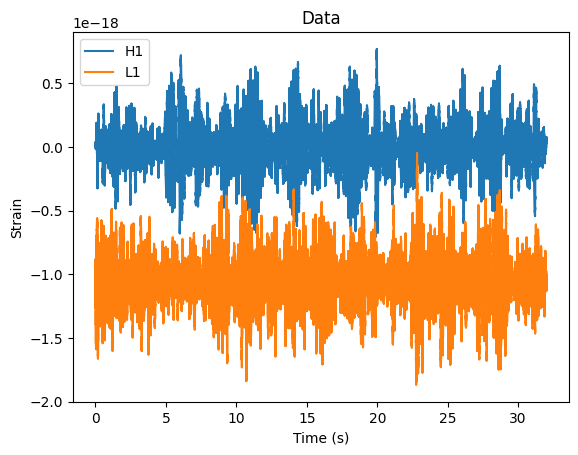

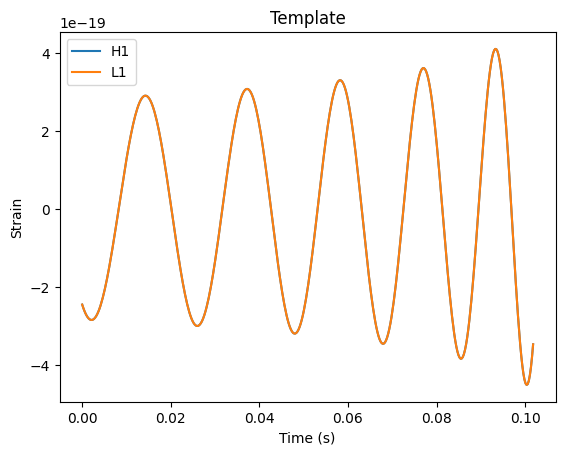

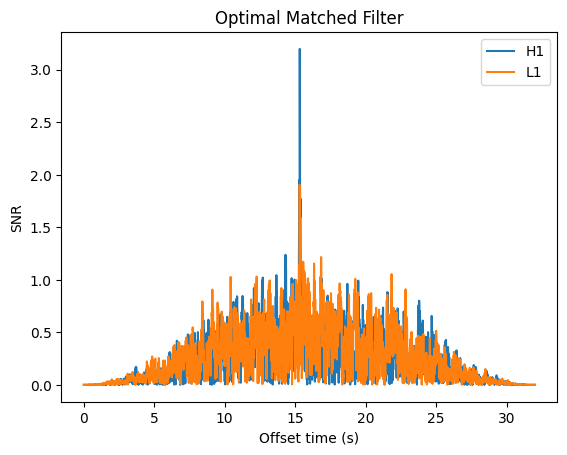

In [6]:
# Use the class to plot gw150914 strain, template and SNR

Matched_Filter(gw150914).plot()

Generate samples of chirp masses and find the best fit template

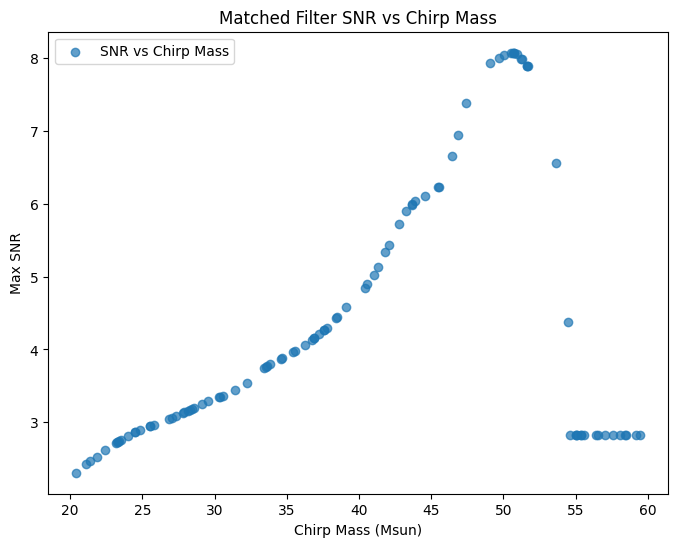

Best Fit Chirp Mass: 50.56 Msun with SNR: 8.07


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 100 random chirp masses in the range 20-60 Msun
M_chirps = np.random.uniform(20, 60, 100)

# Compute SNR for each mass
snrs = [np.max(np.abs(Matched_Filter(gw150914, M).optimal_filter()['H1'])) for M in M_chirps]

# Scatter plot of mass vs. SNR
plt.figure(figsize=(8,6))
plt.scatter(M_chirps, snrs, alpha=0.7, label='SNR vs Chirp Mass')
plt.xlabel('Chirp Mass (Msun)')
plt.ylabel('Max SNR')
plt.title('Matched Filter SNR vs Chirp Mass')
plt.legend()
plt.show()

# Find the best fit mass
best_mass = M_chirps[np.argmax(snrs)]
best_snr = max(snrs)

print(f"Best Fit Chirp Mass: {best_mass:.2f} Msun with SNR: {best_snr:.2f}")
